# Analyse der Störungen der S-Bahn München.

In [1]:
# Helpful functions
import pandas as pd
import numpy as np
import seaborn as sns
import re

# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm as cm

In [2]:
sns.set()

Die letzten Wochen bzw. schon das gesamte Jahr 2018 war eine Katastrophe für die S-Bahn München (https://www.sueddeutsche.de/muenchen/oeffentlicher-nahverkehr-die-muenchner-s-bahn-ist-ein-desaster-1.3890138). Allerdings hat jeder einen subjektiven Eindruck von den Störungen und es gibt einen gewissen Bias bei der Auswahl (andere Strecke, andere Fahrgewohnheiten). Ich fahre selbst häufiger gegen späten Vormittag oder frühen Nachmittag, wohingegen andere ganz früh in die Arbeit oder sehr spät von der Arbeit heimkehren können.

Um die Störungen systematisch anzugehen ist eine Datengrundlage nötig, die alle Störungen beinhaltet und zusätzliche infos (betroffene S-Bahnen) bereitstellt. Die Bahn veröffentlicht selbst zu jeder Störung eine kurze Nachricht, die alle diese Daten beinhaltet. Allerdings gibt es keinen Weg an die Daten der Bahn direkt zu kommen.

Es gibt allerdings Webseiten, welche diese Störungen selbst publizieren und überwachen. Meine Daten der Störungen sind netterweise bereitgestellt von der Website Störticker (https://stoerticker.de/aktuell?evu=2).

## Datensatz: Störungsmelder

Wir laden den Datensatz zu den Störungen und analysieren erst einmal die Struktur der Daten, bevor wir anfangen unsere tiefergehenden Analysen durchzuführen.

Es gibt in der Datenbank ein paar Einträge, die doppelt oder dreifach in die Datenbank geschrieben wurden. Diese entfernen wir und räumen auf. Außerdem schließen wir November von der Analyse aus, weil der Monat noch nicht zu Ende ist und Mittelwerte über die Anzahl der Störungen beeinlussen würde. Das gleiche gilt für den ersten Monat, für den wir Daten haben, September 2013.

In [3]:
stoerungen_raw = pd.read_excel('stoerungen.xlsx')
stoerungen_raw = stoerungen_raw.drop(['id', 'meldung'], axis=1)

stoerungen_raw.columns = ['Text', 'Date']
stoerungen_raw.index = stoerungen_raw['Date']
stoerungen_raw = stoerungen_raw[~stoerungen_raw['Text'].isnull()]

# Error in database - take out the day
stoerungen_raw.groupby('Date').count().sort_values(by='Text', ascending=False).head(10)

# November is manipulating our plots - do not show anything for november yet
stoerungen_raw = stoerungen_raw[stoerungen_raw.index <= '2021-03-31']

# First month: September 2013 is also manipulating our data
stoerungen_raw = stoerungen_raw[stoerungen_raw.index >= '2014-01-01']

stoerungen_raw = stoerungen_raw.drop_duplicates()
stoerungen_raw.index = stoerungen_raw['Date']

In [4]:
stoerungen_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19770 entries, 2014-01-01 06:19:00 to 2021-03-30 20:44:05
Data columns (total 2 columns):
Text    19770 non-null object
Date    19770 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 463.4+ KB


Wir haben Daten von Januar 2014 bis Ende Oktober 2018. Es sind insgesamt 10.379 Störungsmeldungen. Um ein Gefühl für die Daten zu bekommen schauen wir uns die Häufigkeit der verwendeten Worte an und sortieren nach Häufigkeit absteigend. Um ein Gefühl für die Art der Meldungen zu bekommen kann man auch in das Archiv sehen: https://stoerticker.de/archiv?evu=2.

In [73]:
stoerungen_raw['Original_Text'] = stoerungen_raw['Text']
stoerungen_raw['Text'] = stoerungen_raw['Original_Text'].str.lower() \
    .str.strip() \
    .str.replace('&amp;', '&') \
    .str.replace('&quot;', '"') \
    .str.replace('&ndash;', '-') \
    .str.replace('&ouml;', 'ö') \
    .str.replace('ã¶', 'ö') \
    .str.replace('&auml;', 'ä') \
    .str.replace('ã„', 'ä') \
    .str.replace('ã¤', 'ä') \
    .str.replace('&uuml;', 'ü') \
    .str.replace('Ã¼', 'ü') \
    .str.replace('ã¼', 'ü') \
    .str.replace('&szlig;', 'ß') \
    .str.replace('ãÿ', 'ß')

text = stoerungen_raw['Text'] \
    .str.replace(':', '') \
    .str.replace('#', '') \
    .str.replace('/', ' ') \
    .str.replace('\n', '') \
    .str.replace('.', ' ') \
    .str.replace(',', ' ') \
    .str.replace('-', '') \
    .str.replace('(', ' ') \
    .str.replace(')', '') \
    .str.cat(sep=' ')
words = np.unique(text.split(' '))
word_count = dict()
for word in words:
    word_count[word] = text.count(word)
word_count = pd.Series(word_count).to_frame()
word_count.columns = ['Count']
word_count['Word'] = word_count.index

In [74]:
stoerungen_raw.head()

,Text,Date,Original_Text
Date,,,
2014-01-01 06:19:00,stammstrecke: notarzteinsatz / verzögerungen ...,2014-01-01 06:19:00,stammstrecke: notarzteinsatz / verzögerungen ...
2014-01-01 07:34:00,stammstrecke: feueralarm münchen hbf / s-bahne...,2014-01-01 07:34:00,stammstrecke: feueralarm münchen hbf / s-bahne...
2014-01-01 08:00:00,stammstrecke: polizeieinsatz / streckensperrun...,2014-01-01 08:00:00,stammstrecke: polizeieinsatz / streckensperrun...
2014-01-01 08:13:00,1. aktualisierung stammstrecke: streckensperru...,2014-01-01 08:13:00,1. aktualisierung stammstrecke: streckensperru...
2014-01-01 12:33:00,s 4 ebersberg: personen am gleis / streckenspe...,2014-01-01 12:33:00,s 4 ebersberg: personen am gleis / streckenspe...


In [75]:
word_count[word_count['Word'].apply(lambda x: len(str(x))) > 5].sort_values(by='Count', ascending=False).head(30)

,Count,Word
störung,9457,störung
strecke,7025,strecke
verzögerung,5556,verzögerung
verzögerungen,5471,verzögerungen
beeinträchtigung,5321,beeinträchtigung
beeinträchtigungen,5303,beeinträchtigungen
aktualisierung,4859,aktualisierung
stammstreck,4277,stammstreck
stammstrecke,4276,stammstrecke
technisch,4205,technisch


In [76]:
word_count[word_count['Word'].str.startswith('signal')]

,Count,Word
signal,2279,signal
signalanlagen,41,signalanlagen
signalen,127,signalen
signalstörung,1255,signalstörung
signalstörungen,17,signalstörungen


Wir identifizieren folgende "hot words", d.h. Wörter, die häufig im Zusammenhang mit Störungen stehen und nach denen wir in den Meldungen suchen.

In [77]:
hot_words = [
    'störung',
    'verzögerung',
    'verzögerungen',
    'ausfall',
    'beeinträchtigung',
    'beeinträchtigungen',
    'sperrung',
    'streckensperrung',
    'signal',
    'signalstörung',
    'bahnübergang',
    'polizeieinsatz',
    'personen im gleis',
    'stellwerk',
    'polizeiliche ermittlungen',
    'notarzteinsatz',
    'geänderte linienführung',
    'weiche',
    'weichenstörung',
]

Eine interessante erste Analyse ist die Anzahl der Störungsmeldungen pro Monat. Allerdings muss man hier bedenken, dass wir noch keine Aktualisierungen oder sonstige Meldungen, die offensichtlich keine Störungen sind, herausfiltern.

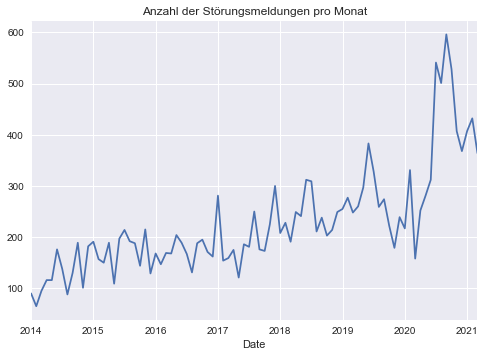

In [197]:
#stoerungen_raw['Text'].groupby(pd.Grouper(freq='W')).count().plot()
stoerungen_raw['Text'].groupby(pd.Grouper(freq='M')).count().plot(title='Anzahl der Störungsmeldungen pro Monat')
plt.savefig("monatliche_stoeorungen.png", dpi=300)
plt.show()

In [233]:
test_df = stoerungen_raw_filtered.loc[stoerungen_raw_filtered.index >= '2020-08-02 16:50:29', ('Text',)].head(50)
test_df["diff"] = test_df["Text"].shift(1) == test_df["Text"]
test_df['Text'].values

array([ 's 7 kreuzstraße: technische störung an einem stellwerk / s-bahnen verkehren wieder nach/von kreuzstraße',
       's 3 mammendorf: gegenstände in der oberleitung / schienenersatzverkehr',
       'stammstrecke: ärztliche versorgung eines fahrgastes / verzögerungen richtung münchen ost',
       's 7 wolfratshausen / s 20 höllriegelskreuth: personen im gleis / streckensperrung',
       's 4/6 ebersberg: polizeieinsatz / beeinträchtigungen',
       's 4/6 ebersberg: polizeieinsatz beendet / folgeverzögerungen',
       's 4 geltendorf: störung an einem bahnübergang / verzögerungen',
       'stammstrecke: störung an der strecke / verzögerungen',
       's 4 / s 6 ebersberg: signalstörung / kein zugverkehr',
       'stammstrecke: störung an der strecke / verzögerungen',
       's 4 / s 6 ebersberg: signalstörung / beeinträchtigungen',
       'stammstrecke: störung an der strecke / verzögerungen',
       's 4 / s 6 ebersberg: signalstörung / verzögerungen',
       'stammstrecke: störun

In [234]:
# Filter out certain words that have nothing to do with problems
filter_out_list = [
    'zusatzangebot mit bussen',
    'aktualisierung',
    '10-minuten-takt',
    'kurzfristiger rückstau im berufsverkehr',
    'fahrplananpassungen',
    'endmeldung',
    'stellwerksstörung behoben',
    'rückkehr zum regelfahrplan bei der s-bahn münchen',
    'bauarbeiten auf der stammstrecke',
    'behoben',
    'stammstrecke: bauarbeiten',
    'vorangegangen',
    'sperrung aufgehoben',
    'wieder aufgenommen',
    'wieder normalisiert',
    'verkehrslage normalisiert sich',
    'einstellung der zusatzangebote mit bussen',
    'weiterhin beeinträchtigungen',
    'ist eingerichtet',
    'wieder auf regelweg'
]
stoerungen_raw_filtered = stoerungen_raw.loc[~stoerungen_raw['Text'].str.contains('|'.join(filter_out_list))]

# Filter out consecutive duplicates
stoerungen_raw_filtered = stoerungen_raw_filtered.loc[~(stoerungen_raw_filtered.loc[:, 'Text'].shift(1) == stoerungen_raw_filtered.loc[:, 'Text'])]

# Filter also consecutive almost duplicates
slice_indices = stoerungen_raw_filtered.loc[:, 'Text'].str.rfind(' / ')
main_text = pd.Series([x[:y] for x, y in zip(stoerungen_raw_filtered['Text'], slice_indices)])
main_text.index = stoerungen_raw_filtered.index
stoerungen_raw_filtered = stoerungen_raw_filtered.loc[~(main_text.shift(-1) == main_text)]

stoerungen_raw_filtered.shape

(8976, 3)

Im nächsten Schritt sehen wir uns die Verwendung der "hot words" in Meldungen an. Wir filtern die Meldungen, welche diese Worte beinhalten.

In [235]:
stoerungen_hotwords = stoerungen_raw_filtered[stoerungen_raw_filtered['Text'].str.contains('|'.join(hot_words))]

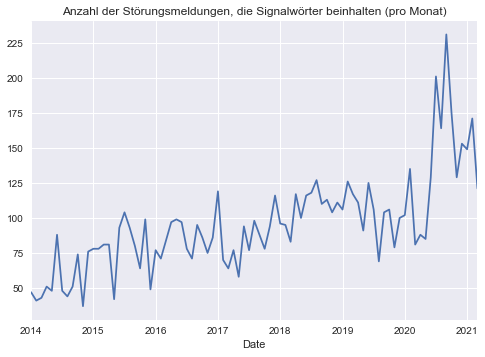

In [236]:
stoerungen_hotwords['Text'].groupby(pd.Grouper(freq='M')).count().plot(title='Anzahl der Störungsmeldungen, die Signalwörter beinhalten (pro Monat)')
plt.savefig("monatliche_stoeorungen_hotwords.png", dpi=300)
plt.show()

Wenn man sich die Struktur einer Meldung genauer ansieht, dann beschreibt der Text vor dem ersten Doppelpunkt meist die Art der Meldung (Aktualisierung / Störung / etc.) und nennt die betroffenen S-Bahnen und der darauffolgende Text gibt Details zur Art der Störung. Deshalb spalten wir nun alle Meldungen in genau diese Bestandteile zur genaueren Analyse.

In [250]:
text_split = stoerungen_raw_filtered['Text'].str.lower().str.strip()
#text_split = stoerungen_hotwords['Text'].str.lower().str.strip()

regexp = r'(.+):{1} {1}(.*)\({1}(.+)[\)9]{0,1}'
res = text_split.str.extract(pat=regexp, expand=True)
res.columns = ['Type', 'Text', 'Date']
nantext = pd.isnull(res['Type'])
res.loc[nantext, 'Type'] = text_split[nantext]
res.loc[nantext, 'Text'] = text_split[nantext]
print('No match for {} entries'.format(np.sum(nantext)))

# stoerungen = res[~nantext]
stoerungen = res
stoerungen.head()

No match for 1968 entries


,Type,Text,Date
Date,,,
2014-01-01 06:19:00,stammstrecke,notarzteinsatz / verzögerungen,"stand 01.01.2014, 06:20 uhr)"
2014-01-01 07:34:00,stammstrecke,feueralarm münchen hbf / s-bahnen verkehren oh...,"stand 01.01.2014, 07:35 uhr)"
2014-01-01 08:00:00,stammstrecke,polizeieinsatz / streckensperrung,"stand 01.01.2014, 08:00 uhr)"
2014-01-01 12:33:00,s 4 ebersberg,personen am gleis / streckensperrung,"stand 01.01.2104, 12:30 uhr)"
2014-01-02 08:21:00,stammstrecke,verzögerungen richtung münchen-ost,"stand 02.01.14, 08:20 uhr)"


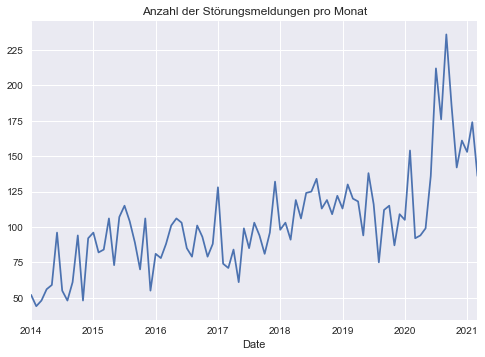

In [251]:
#stoerungen_raw['Text'].groupby(pd.Grouper(freq='W')).count().plot()
stoerungen['Text'].groupby(pd.Grouper(freq='M')).count().plot(title='Anzahl der Störungsmeldungen pro Monat')
plt.show()

Wir nehmen nur die Meldungen, wo diese Aufspaltung ein sinnvolles Ergebnis erzeugt und extrahieren einen Typ der Meldung (`type`), einen Text (`Text`) und ein Datum (`Date`).

Als nächstes filtern wir Störungsmeldungen, die häufig auftreten, die aber unsere Analyse nicht verfälschen sollen heraus. Dazu gehören die häufigen Aktualisierungen zu Störungsmeldungen (wir möchten nur die erste, ursprüngliche Störungsmeldung zählen und analysieren) und nehmen auch die häufigen Meldungen zum Ausfall von S-Bahnen des 10-Minuten-Taktes hinaus, weil das meist mit einer Störung zusammenhängt und wir diese dann doppelt oder dreifach zählen würden. Insgesamt möchten wir eher eine Störung nicht zählen, als eine zu viel.

In [252]:
stoerungen_without_10mtakt = stoerungen[~stoerungen['Text'].str.contains('10-minuten-takt')]

# types = np.unique(stoerungen['Type'])
types = np.unique(stoerungen_without_10mtakt['Type'])
types_freq = pd.DataFrame({'Words': types, 'Freq': [np.sum(stoerungen_without_10mtakt['Type'] == typ) for typ in types]})

Hier filtern wir diejenigen Störungen hinaus, die im Typ das Wort Aktualisierung beinhalten. (Die Variable `Keep` beschreibt, ob wir die Meldung behalten möchten oder nicht.)

In [253]:
types_freq['Keep'] = ~types_freq['Words'].str.contains('aktualisierung')

Wir können uns nun diejenigen Meldungstypen mit dem höchsten Auftreten ansehen. Erwartungsgemäß tritt hier die Stammstrecke am häufigsten auf.

In [254]:
types_freq[types_freq['Keep']].sort_values(by='Freq', ascending=False).head(20)

,Freq,Words,Keep
1659,1368,stammstrecke,True
1303,476,s 7 wolfratshausen,True
531,402,s 2 erding,True
345,305,s 1 freising/flughafen,True
1447,302,s 8 herrsching,True
975,290,s 4 geltendorf,True
1240,273,s 7 kreuzstraße,True
284,260,s 1 freising / flughafen,True
784,247,s 3 holzkirchen,True
1157,228,s 6 tutzing,True


Als nächsten sehen wir uns die Erwähnungen der S-Bahnlinien in diesen Meldungen an und zählen sie.

In [255]:
sbahnlinien = ['1', '2', '3', '4', '6', '7', '8']
mentions = dict()

for sbahnlinie in sbahnlinien:
    mentions['S{}'.format(sbahnlinie)] = types_freq['Freq'][(types_freq['Words'].str.contains('s {}'.format(sbahnlinie)) | types_freq['Words'].str.contains('s{}'.format(sbahnlinie))) & types_freq['Keep']].sum()

freq = pd.Series(list(mentions.values()))
sbahnlinie = pd.Series(list(mentions.keys()))
m = pd.concat([sbahnlinie, freq], axis=1)
m.columns = ['S-Bahnlinie', 'Mentions']
m

,S-Bahnlinie,Mentions
0,S1,1133
1,S2,1380
2,S3,729
3,S4,968
4,S6,845
5,S7,1397
6,S8,1030


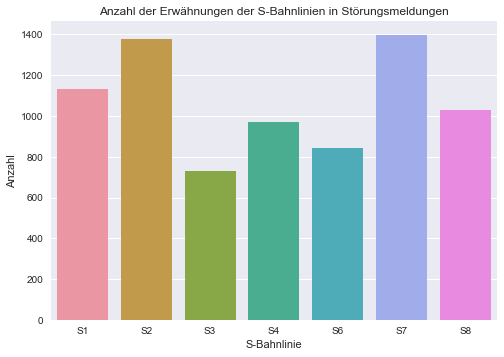

In [256]:
fig, ax = plt.subplots()
sns.barplot(x='S-Bahnlinie', y='Mentions', data=m)
plt.title('Anzahl der Erwähnungen der S-Bahnlinien in Störungsmeldungen')
ax.set_ylabel('Anzahl')
plt.savefig("stoerungen_nach_sbahnlinie.png", dpi=300)
plt.show()

In [257]:
def plot_linien_stoerungen(sbahnlinie):
    
    monthly_stoerungen_without_updates = stoerungen['Type'][(stoerungen['Type'].str.contains('s {}'.format(sbahnlinie)) |
                                                             stoerungen['Type'].str.contains('s{}'.format(sbahnlinie)) |
                                                             stoerungen['Type'].str.contains('stammstrecke')) &
                                                            ~stoerungen['Type'].str.contains('aktualisierung') & ~stoerungen['Text'].str.contains('10-minuten-takt')] \
        .groupby(pd.Grouper(freq='M')).count()
    monthly_stoerungen = stoerungen['Type'][(stoerungen['Type'].str.contains('s {}'.format(sbahnlinie)) |
                                             stoerungen['Type'].str.contains('s{}'.format(sbahnlinie)) |
                                             stoerungen['Type'].str.contains('stammstrecke')) &
                                            ~stoerungen['Text'].str.contains('10-minuten-takt')] \
        .groupby(pd.Grouper(freq='M')).count()

    monthly_stoerungen_without_updates.plot(label='Anzahl')
    monthly_stoerungen_without_updates.rolling(6).mean().plot(title='Anzahl der Störungsmeldungen für die S{} (pro Monat)'.format(sbahnlinie), label='Trendlinie')
    #monthly_stoerungen.plot(label='Count updates')

    #(monthly_stoerungen - monthly_stoerungen_without_updates).plot(label='Difference')

    plt.legend()
    #plt.axhline(y=monthly_stoerungen_without_updates.mean(), color='red')
    #plt.savefig("monatliche_stoeorungen_s{}.png".format(sbahnlinie), dpi=300)
    plt.show()

Als nächstes folgen Grafiken für die S-Bahnlinien zur Anzahl der monatlichen Störungen für die jeweilige S-Bahnlinie (Störungen der Stammstrecke, die alle Linien betreffen, sind hier auch eingerechnet). Weiterhin ist die 6-Monats-Trendlinie eingezeichnet.

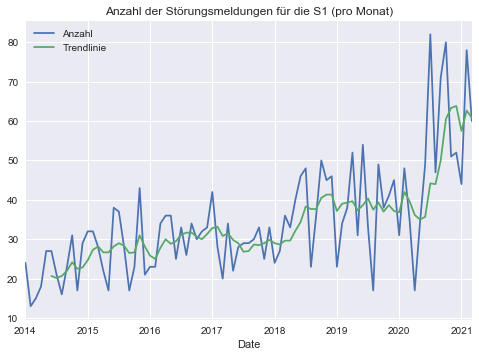

In [258]:
plot_linien_stoerungen(1)

Für die S2 und S8 sollte man bedenken, dass wir die Meldungen zum Ausfall der S-Bahnen des 10-Minuten-Taktes entfernt haben.

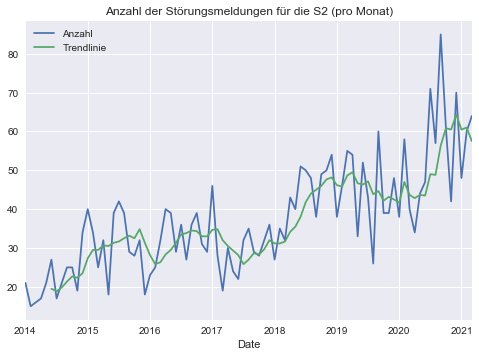

In [259]:
plot_linien_stoerungen(2)

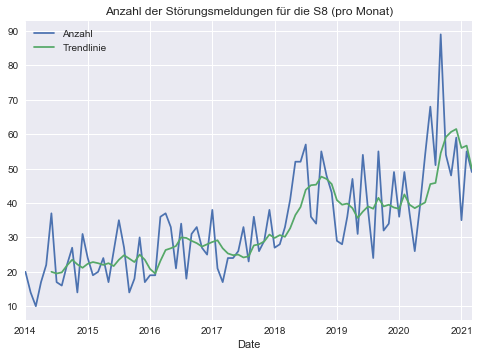

In [260]:
plot_linien_stoerungen(8)

Die letzte Grafik dieser Serie zeigt die Störungen der Stammstrecke (Sxxx).

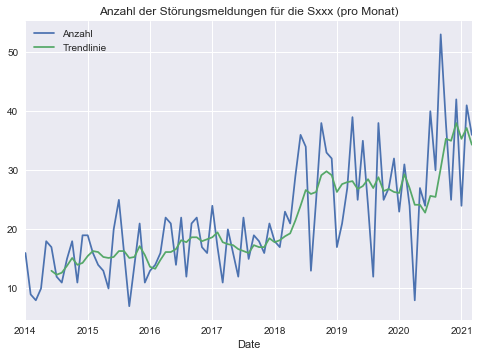

In [261]:
plot_linien_stoerungen('xxx') # results in the disruptions for the stammstrecke

## Gesundheit des Systems

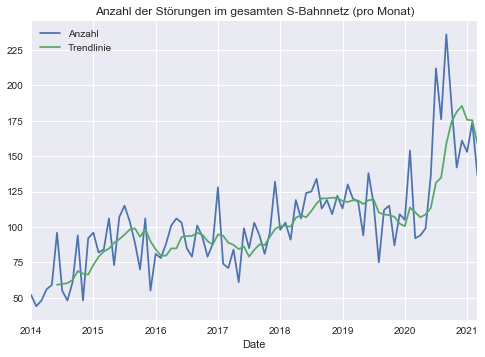

In [262]:
monthly_stoerungen_without_updates = stoerungen['Type'][~stoerungen['Type'].str.contains('aktualisierung') & ~stoerungen['Text'].str.contains('10-minuten-takt')].groupby(pd.Grouper(freq='M')).count()
monthly_stoerungen_without_updates.plot(label='Anzahl')
monthly_stoerungen_without_updates.rolling(6).mean().plot(title='Anzahl der Störungen im gesamten S-Bahnnetz (pro Monat)', label='Trendlinie')
plt.legend()
plt.show()

## Störungen nach Jahreszeit

Von der Bahn so kommuniziert und eine weitverbreitete Ansicht ist, dass die Zahl der Störungen im Winter nach oben geht und im Sommer eher niedrig ist (Weichen frieren ein, Oberleitungen haben Probleme wegen der Kälte, etc.). Dies können wir an den Daten nun direkt überprüfen. Wir sehen uns dafür die Anzahl der monatlichen Störungen an und teilen die Monate in Kategorien ein.

Wir richten uns nach dem metereologischen Beginn der Jahreszeiten. Das ist damit folgende Einteilung.

| Frühling          | Sommer               | Herbst                       | Winter                        |
|-------------------|----------------------|------------------------------|-------------------------------|
| 1. März - 31. Mai | 1. Juni - 31. August | 1. September - 30. November  | 1. Dezember - 28./29. Februar |
| März, April, Mai  | Juni, Juli, August   | September, Oktober, November | Dezember, Januar, Februar     |

In [165]:
seasons = {
    'Frühling': [3, 4, 5],
    'Sommer': [6, 7, 8],
    'Herbst': [9, 10, 11],
    'Winter': [12, 1, 2],
}

In [166]:
stoerungen_for_month = monthly_stoerungen_without_updates.groupby(by=[monthly_stoerungen_without_updates.index.month]).mean().to_frame()
stoerungen_for_month.columns = ['Durchschnittliche Anzahl']
stoerungen_for_month['Monat'] = stoerungen_for_month.index
stoerungen_for_month['Jahreszeit'] = stoerungen_for_month.index

for season, months in seasons.items():
    stoerungen_for_month.loc[stoerungen_for_month['Monat'].isin(months), 'Jahreszeit'] = season

stoerungen_for_season = stoerungen_for_month.groupby(by='Jahreszeit').mean()
stoerungen_for_season['Jahreszeit'] = stoerungen_for_season.index
stoerungen_for_season

,Durchschnittliche Anzahl,Monat,Jahreszeit
Jahreszeit,,,
Frühling,82.071429,4,Frühling
Herbst,85.714286,10,Herbst
Sommer,90.476190,7,Sommer
Winter,92.214286,5,Winter


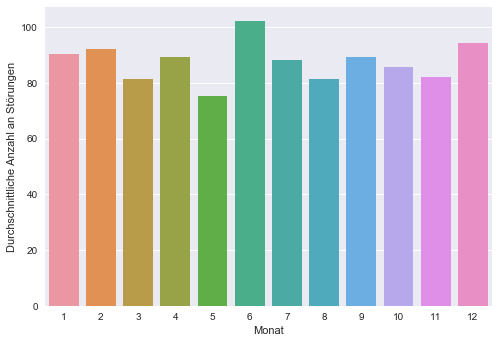

In [167]:
fig, ax = plt.subplots()
sns.barplot(x='Monat', y='Durchschnittliche Anzahl', data=stoerungen_for_month)
ax.set_ylabel('Durchschnittliche Anzahl an Störungen')
plt.savefig("stoerungen_nach_monat.png", dpi=300)
plt.show()

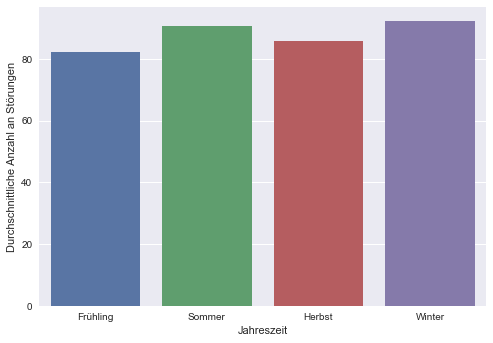

In [168]:
fig, ax = plt.subplots()
sns.barplot(x='Jahreszeit', y='Durchschnittliche Anzahl', data=stoerungen_for_season.loc[("Frühling", "Sommer", "Herbst", "Winter"),:])
ax.set_ylabel('Durchschnittliche Anzahl an Störungen')
plt.savefig("stoerungen_nach_jahreszeit.png", dpi=300)
plt.show()

In [169]:
stoerungen_without_updates_per_hour = stoerungen['Type'][~stoerungen['Type'].str.contains('aktualisierung') & ~stoerungen['Text'].str.contains('10-minuten-takt')].groupby(pd.Grouper(freq='1h')).count()
stoerungen_without_updates_per_hour = stoerungen_without_updates_per_hour.to_frame()
stoerungen_without_updates_per_hour['timeofday'] = ''

In [170]:
hours = stoerungen_without_updates_per_hour.index.hour
splitting = [0, 6, 9, 12, 15, 18, 21, 24]
sorting = []

for i in range(1, len(splitting)):
    selection = (splitting[i-1] <= hours) & (hours <= splitting[i])
    timeofday = '{} - {}'.format(splitting[i-1], splitting[i])
    sorting.append(timeofday)
    stoerungen_without_updates_per_hour.loc[selection, 'timeofday'] = timeofday

In [171]:
stoerungen_for_timeofday = stoerungen_without_updates_per_hour.groupby(by='timeofday').sum()
stoerungen_for_timeofday['Tageszeit'] = stoerungen_for_timeofday.index
stoerungen_for_timeofday['Anzahl'] = stoerungen_for_timeofday['Type']
stoerungen_for_timeofday = stoerungen_for_timeofday.loc[sorting,]
stoerungen_for_timeofday

,Type,Tageszeit,Anzahl
timeofday,,,
0 - 6,452,0 - 6,452
6 - 9,1609,6 - 9,1609
9 - 12,1038,9 - 12,1038
12 - 15,1051,12 - 15,1051
15 - 18,1669,15 - 18,1669
18 - 21,1264,18 - 21,1264
21 - 24,541,21 - 24,541


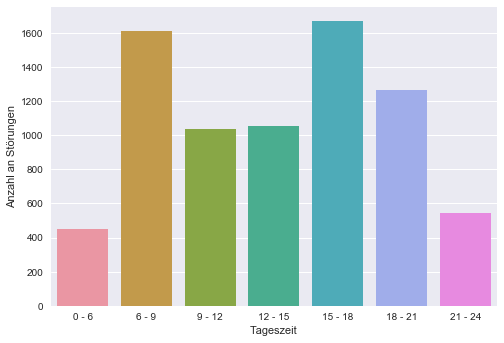

In [172]:
fig, ax = plt.subplots()
sns.barplot(x='Tageszeit', y='Anzahl', data=stoerungen_for_timeofday)
ax.set_ylabel('Anzahl an Störungen')
plt.savefig("stoerungen_nach_tageszeit.png", dpi=300)
plt.show()